## [Molecular Dynamics with DeePMD](https://github.com/deepmodeling/deepmd-kit) [<a href="https://tutorials.deepmodeling.com/en/latest/" style="color:orange">DeepModeling Tutorial!</a>]

#### Required Libraries : [numpy](https://pypi.org/project/numpy/), [deepmd](https://github.com/deepmodeling/deepmd-kit),[dpdata](https://github.com/deepmodeling/dpdata), [ase](https://pypi.org/project/ase/), [matplotlib](https://pypi.org/project/matplotlib/)

<p style="text-align:justify;">This tutorial introduces a Machine Learning Interatomic Potential (MLP) model called DeePMD. 

This particular tutorial is for the **1,3-Butadiene** cyclization. The steps to build the MLP contain three stages:

1. Data generation
2. Training
3. Molecular Dynamics

For data generation, we will use the [VASP](https://www.vasp.at/) package. 

Here, I am not going to explain how to generate the initial configuration. However, there are several ways to do that. The easiest way is to perform a classical MD simulation and then take the (M) random configurations and do the *ab-initio* calculations to get the potential energy and corresponding forces (in this case, we will be using Quantum Espresso).

The initial 4400 configurations (input and output) are stored in the <span style="color:olive">**POSCAR**</span> and <span style="color:olive">**OUTCAR**</span> folders inside the *00.data* directory. (You can re-run the inputs if you want).

</p>


In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [8]:
!pwd

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/04.um_dynamics/analysis


In [2]:
prefix_path = os.getcwd()
print(prefix_path)

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/04.um_dynamics


In [3]:
os.chdir(
    os.path.join(prefix_path, 'analysis')
)
!pwd
!ls

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/04.um_dynamics/analysis
av_dfds.dat            free_energy_2D.dat     interpolated_fes.dat
butad_fes.jpeg         input.inp              plot_fes.py
fes.dat                input.tass             run.sh
free_energy.dat        interp_free_energy.dat


In [4]:
# Load the data
dft_fes_data = np.loadtxt('fes.dat', comments='!', skiprows=5, usecols=(0, 1))
dpmd_fes_data = np.loadtxt('interp_free_energy.dat', usecols=(0, 1))

#
print(f"DFT: \n {dft_fes_data[1:5]}, \n DeePMD: \n {dpmd_fes_data[1:5]}")

DFT: 
 [[ 0.7148395  48.8225759 ]
 [ 0.78459    48.75265659]
 [ 0.8543405  48.557655  ]
 [ 0.924091   48.07544632]], 
 DeePMD: 
 [[  1.41857143  -9.44430566]
 [  1.42785714  -9.92960753]
 [  1.43714286 -10.38017597]
 [  1.44642857 -10.79645904]]


In [5]:
# Separate positions and PMFs
dft_fes_pos, dft_fes_pmf = dft_fes_data[:, 0], dft_fes_data[:, 1]
dpmd_fes_pos, dpmd_fes_pmf = dpmd_fes_data[:, 0], dpmd_fes_data[:, 1]

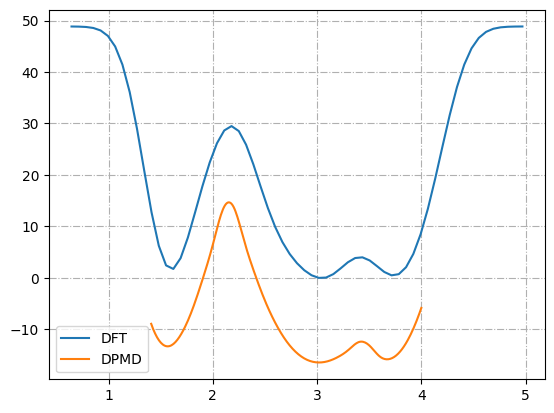

In [6]:
plt.plot(dft_fes_pos, dft_fes_pmf, label='DFT')
plt.plot(dpmd_fes_pos, dpmd_fes_pmf, label='DPMD')

plt.legend()
plt.grid(ls='-.')
plt.show()

plt.show()

<div class="alert alert-block alert-success">
    <b>Info:</b> <span style="font-size: 1.2em; color: green;">Both plots are shifted along the Y-axis. Let's align these with respect to a certain value of X.<br>
    Also, since the <code style="background-color: Azure;">DPMD</code> has no data after a certain X-range, we will create a mask to filter out data outside this range: <code style="background-color: Azure;">[xmin: 1.4, xmax: 4.0]</code></span>
</div>


In [20]:
# Separate positions and PMFs
dft_fes_pos, dft_fes_pmf = dft_fes_data[:, 0], dft_fes_data[:, 1]
dpmd_fes_pos, dpmd_fes_pmf = dpmd_fes_data[:, 0], dpmd_fes_data[:, 1]

# Min and Max position at which PMF is considerd
min_pos, max_pos = 1.4, 4.0

# create a mask array to filter the positions outside of range (type[boolean: True or False])
dft_mask = (dft_fes_pos >= min_pos) & (dft_fes_pos <= max_pos)
dpmd_mask = (dpmd_fes_pos >= min_pos) & (dpmd_fes_pos <= max_pos)

# Filter the positions outside of the range
dft_fes_pos = dft_fes_pos[dft_mask]
dft_fes_pmf = dft_fes_pmf[dft_mask]
dpmd_fes_pos = dpmd_fes_pos[dpmd_mask]
dpmd_fes_pmf = dpmd_fes_pmf[dpmd_mask]

# Find the PMF values at position 3.0 for both datasets
pos_x = 3.0
dft_pmf_at_position = np.interp(pos_x, dft_fes_pos, dft_fes_pmf)
dpmd_pmf_at_position = np.interp(pos_x, dpmd_fes_pos, dpmd_fes_pmf)

# Calculate the difference at the specific position
alignment_shift = dft_pmf_at_position - dpmd_pmf_at_position

# Align dpmd_fes_pmf with dft_fes_pmf at position 3.0
dpmd_fes_pmf += alignment_shift

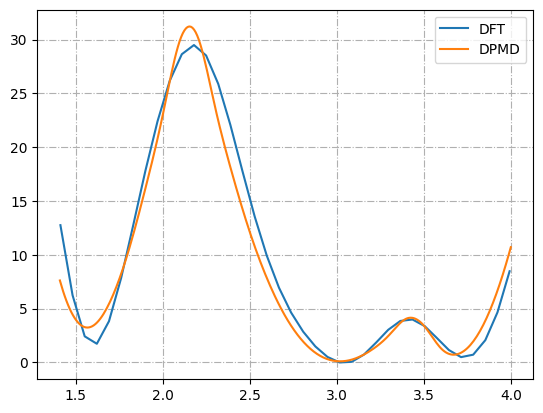

In [21]:
plt.plot(dft_fes_pos, dft_fes_pmf, label='DFT')
plt.plot(dpmd_fes_pos, dpmd_fes_pmf, label='DPMD')

plt.legend()
plt.grid(ls='-.')
plt.show()

plt.show()

[Root Mean Square Deviation (RMSD) metrics:](https://pubs.acs.org/doi/suppl/10.1021/acs.jctc.5b00846/suppl_file/ct5b00846_si_001.pdf)

<center>

$$  RMSD(F, G) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} [(F(S_i) - {\left \langle F(S) \right \rangle}) - (G(S_i) - {\left \langle G(S) \right \rangle})]^2} $$

</center>
<br>

#### where, 𝑆 is a collective variable, 𝐹(𝑆) and <F(𝑆)> are the exact and estimated free energies averaged over N.

In [22]:
# # Interpolate PMFs to common coordinates within the range 1.4 to 4.0
# # numpy.union1d(ar1, ar2) -> Return the unique, sorted array of values that are in either of the two input arrays.
# X_pos = np.union1d(dft_fes_pos, dpmd_fes_pos)

# # numpy.interp -> One-dimensional linear interpolation
# dft_fes_pmf_interp = np.interp(X_pos, dft_fes_pos, dft_fes_pmf)
# dpmd_fes_pmf_interp = np.interp(X_pos, dpmd_fes_pos, dpmd_fes_pmf)

# Scipy interpolation
X_pos = np.linspace(min_pos, max_pos, num=500)  # num --> number of interpolation points
dft_fes_pmf_interp = interp1d(dft_fes_pos, dft_fes_pmf, kind='linear', fill_value='extrapolate')(X_pos)
dpmd_fes_pmf_interp = interp1d(dpmd_fes_pos, dpmd_fes_pmf, kind='linear', fill_value='extrapolate')(X_pos)

# Calculate Root Mean Square Deviation (RMSD) with respect to the minimum PMF at postion 3.0
rmsd = np.sqrt(np.mean((dft_fes_pmf_interp - dpmd_fes_pmf_interp) ** 2))
print("RMSD:", rmsd)

# Save interpolated FES and positions to a file using numpy.vstack -> Stack arrays
output_data = np.vstack((X_pos, dft_fes_pmf_interp, dpmd_fes_pmf_interp)).T
np.savetxt('interpolated_fes.dat', output_data, header='#Position, DFT_FES_PMF, DPMD_FES_PMF', comments='')

# for i in range(len(common_positions)):
#     print(common_positions[i], dft_fes_pmf_interpolated[i], dpmd_fes_pmf_interpolated[i])

print("Interpolated FES and positions saved to 'interpolated_fes.dat'.")

RMSD: 1.701638062552644
Interpolated FES and positions saved to 'interpolated_fes.dat'.


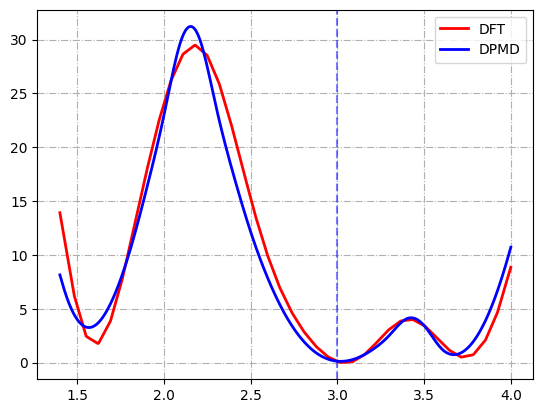

In [23]:
dt = np.loadtxt('interpolated_fes.dat', skiprows=1)

plt.plot(dt[:,0], dt[:,1], c='r', lw=2, label='DFT')
plt.plot(dt[:,0], dt[:,2], c='b', lw=2, label='DPMD')

plt.axvline(x = 3, color = 'b', ls='--', alpha=0.5)

plt.legend()
plt.grid(ls='-.')
plt.show()